In [46]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as offline
from folium.plugins import HeatMapWithTime
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium import FeatureGroup
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely import wkt
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union
import geopandas as gpd
from geopandas import GeoSeries
import pyproj
from tqdm import tqdm
from keplergl import KeplerGl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# tqdmÏùò pandasÏ†ÑÏö© Î©îÏÜåÎìúÎ•º Ìò∏Ï∂ú
tqdm.pandas()
# Î™®Îì† Ïó¥Ïù¥ ÏÉùÎûµÎêòÏßÄ ÏïäÎèÑÎ°ù ÏÑ§Ï†ï
pd.set_option('display.max_columns', None)
 
# PointÎ•ºÎßåÎìúÎäî Ìï®Ïàò
def make_point(x):
    try:
        return Point(x)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
# PolygonÏùÑ ÎßåÎìúÎäî Ìï®Ïàò
def make_pol(x):
    try:
        return Polygon(x[0])
    except:
        return Polygon(x[0][0])
    
# LinestringÏùÑ ÎßåÎìúÎäî Ìï®Ïàò
def make_lin(x):
    try:
        return LineString(x)
    except:
        return LineString(x[0])

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ GeoPandas Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Î≥ÄÌôòÌïòÎäî Ìï®Ïàò Ï†ïÏùò
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat dataÎ•º geometryÎ°ú Î≥ÄÍ≤Ω
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.progress_apply(lambda row : Point([row['lon'], row['lat']]), axis=1) # ÏúÑÎèÑ Î∞è Í≤ΩÎèÑÎ°§ GeoPandas Point Í∞ùÏ≤¥Î°ú Î≥ÄÌôò
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'} # geopandas Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùò Ï¢åÌëúÍ≥ÑÎ•º EPSG 4326ÏúºÎ°ú ÏÑ§Ï†ï
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùò Ï¢åÌëúÍ≥ÑÎ•º ÏûêÏ≤¥ Ï¢åÌëúÍ≥ÑÏóêÏÑú EPSG 4326ÏúºÎ°ú Î≥ÄÌôò
    return DataFrame

#### ÌñâÏ†ïÍ≤ΩÍ≥Ñ

In [47]:
dj_b = pd.read_csv("./ÎåÄÏ†ÑÏãú_ÌñâÏ†ïÍ≤ΩÍ≥Ñ.csv")
dj_b["geometry"] = dj_b["geometry"].apply(wkt.loads)
dj_b = gpd.GeoDataFrame(dj_b, geometry="geometry")
dj_pol = dj_b.dissolve(by=None)
dj_geo_dic = dict(zip(dj_b['ADM_CD'], dj_b['geometry']))

#### Í≤©ÏûêÎã®ÏúÑ(ÎåÄÏ†Ñ)

In [48]:
# ÎîîÎ†âÌÜ†Î¶¨ Í≤ΩÎ°ú
shp_dir1 = "./Í≤©ÏûêÎã®ÏúÑ/_grid_border_grid_2023_grid_Îã§Îßà_grid_Îã§Îßà"
shp_dir2 = "./Í≤©ÏûêÎã®ÏúÑ/_grid_border_grid_2023_grid_Îã§Î∞î_grid_Îã§Î∞î"
shp_dir3 = "./Í≤©ÏûêÎã®ÏúÑ/_grid_border_grid_2023_grid_ÎùºÎ∞î_grid_ÎùºÎ∞î"

# ÎîîÎ†âÌÜ†Î¶¨ ÎÇ¥ .shp ÌååÏùº Ï∞æÍ∏∞
shp_files1 = [f for f in os.listdir(shp_dir1) if f.endswith('.shp')]
shp_files2 = [f for f in os.listdir(shp_dir2) if f.endswith('.shp')]
shp_files3 = [f for f in os.listdir(shp_dir3) if f.endswith('.shp')]

# Ï≤´ Î≤àÏß∏ .shp ÌååÏùº ÏùΩÍ∏∞
shp_path = os.path.join(shp_dir1, shp_files1[0])
gdf1 = gpd.read_file(shp_path)
gdf1 = gdf1.to_crs(epsg=4326)

# Îëê Î≤àÏß∏ .shp ÌååÏùº ÏùΩÍ∏∞
shp_path = os.path.join(shp_dir2, shp_files2[0])
gdf2 = gpd.read_file(shp_path)
gdf2 = gdf2.to_crs(epsg=4326)

# ÏÑ∏ Î≤àÏß∏ .shp ÌååÏùº ÏùΩÍ∏∞
shp_path = os.path.join(shp_dir3, shp_files3[0])
gdf3 = gpd.read_file(shp_path)
gdf3 = gdf3.to_crs(epsg=4326)

# Ìè¥Î¶¨Í≥§ ÌÜµÌï©
gdf_con = pd.concat([gdf1, gdf2, gdf3]).reset_index(drop=True)
gdf_con.rename(columns={'GRID_1K_CD' : 'grid_cd'}, inplace=True)

# ÎåÄÏ†Ñ Í≤©ÏûêÎ°úÎßå ÌïÑÌÑ∞ÎßÅ
dj_grid = gdf_con[gdf_con.intersects(dj_pol.unary_union)]

dj_grid_dic = dict(zip(dj_grid['grid_cd'], dj_grid['geometry']))

#### Í≤©ÏûêÎã®ÏúÑ(ÌÉÑÏÜåÎ∞∞Ï∂ú)

In [85]:
co2 = pd.read_csv("./Í≤©ÏûêÎã®ÏúÑ/ÌÉÑÏÜåÎ∞∞Ï∂ú Ï¥ùÍ¥Ñ_Ï†ÑÏ≤¥_Í≤©Ïûê_1km_2022.csv", encoding='cp949')
dj_co2 = co2[co2['grid_cd'].isin(dj_grid['grid_cd'].tolist())]
dj_co2['geometry'] = dj_co2['grid_cd'].map(dj_grid_dic)

dj_co2 # Ïù¥ Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏóê Í≤©ÏûêÌÜµÍ≥Ñ Ï∂îÍ∞ÄÌï† Í≤É

C:\Users\user\AppData\Local\Temp\ipykernel_19252\944018120.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



grid_cd  emissions                                           geometry
136     ÎùºÎ∞î0013      62.71  POLYGON ((127.50000000000001 36.31434675521236...
144     ÎùºÎ∞î0014      65.21  POLYGON ((127.50000000000001 36.32336221829146...
151     ÎùºÎ∞î0015    1240.97  POLYGON ((127.50000000000001 36.33237766774219...
159     ÎùºÎ∞î0016     922.49  POLYGON ((127.50000000000001 36.34139310356320...
167     ÎùºÎ∞î0017    7123.83  POLYGON ((127.50000000000001 36.35040852575323...
...        ...        ...                                                ...
105974  Îã§Î∞î9924      27.36  POLYGON ((127.48884610188327 36.41351557840409...
105984  Îã§Î∞î9925       0.00  POLYGON ((127.48884481266187 36.42253089132852...
105994  Îã§Î∞î9926       0.00  POLYGON ((127.48884352286736 36.43154619061015...
106004  Îã§Î∞î9927       0.00  POLYGON ((127.48884223249948 36.44056147624773...
106015  Îã§Î∞î9928       0.47  POLYGON ((127.48884094155795 36.44957674823991...

[632 rows x 3 columns]

#### Ï£ºÌñâÍ±∞Î¶¨

In [71]:
tot_2022 = pd.read_csv("./2022ÏàòÏ†ïÎ≥∏/tot_2022.csv")
tot_2022["geometry"] = tot_2022["geometry"].apply(wkt.loads)
tot_2022 = gpd.GeoDataFrame(tot_2022, geometry="geometry")

<Axes: >

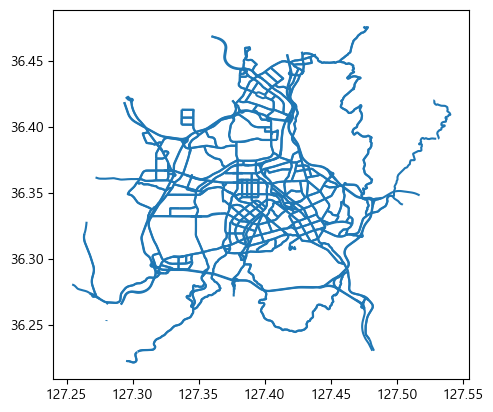

In [68]:
# 1. ÎåÄÏ†ÑÏãú ÌñâÏ†ïÎèô Ìè¥Î¶¨Í≥§ÏùÑ ÌïòÎÇòÏùò ÌÅ∞ Ìè¥Î¶¨Í≥§ÏúºÎ°ú Ìï©ÏπòÍ∏∞
merged_polygon = dj_pol['geometry'].iloc[0]  # GeoSeriesÏóê Ï†ÅÏö©

# 2. ÎèÑÎ°ú Îç∞Ïù¥ÌÑ∞Ïùò ÎùºÏù∏Ïä§Ìä∏ÎßÅÏùÑ ÌÜµÌï© Ìè¥Î¶¨Í≥§ ÎÇ¥ÏóêÏÑú ÏûêÎ•¥Í∏∞
tot_2022["geometry"] = tot_2022.geometry.apply(lambda x: x.intersection(merged_polygon))

# 3. ÌÅ¥Î¶¨Ìïë ÌõÑ Í∏∏Ïù¥Í∞Ä 0Ïù¥ Îêú ÎèÑÎ°ú Ï†ïÎ≥¥ Ï†úÍ±∞ (Îπà ÎèÑÌòï Î∞©ÏßÄ)
tot_2022 = tot_2022[~tot_2022.geometry.is_empty]

# 4. Í≤∞Í≥º ÏãúÍ∞ÅÌôî
tot_2022.plot()


#### Í≤©ÏûêÎ≥Ñ ÍµêÌÜµÎüâ Í≥ÑÏÇ∞

C:\Users\user\AppData\Local\Temp\ipykernel_19252\1448383347.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



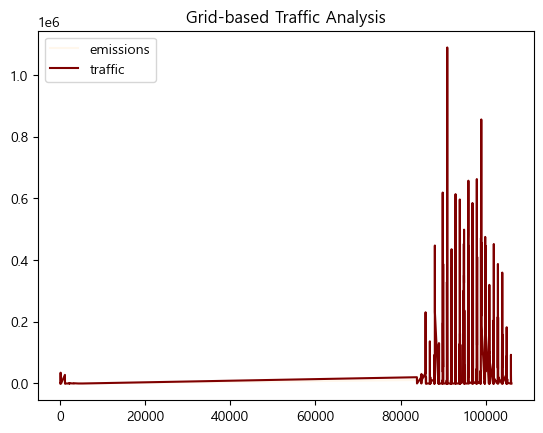

In [89]:

tot_2022["traffic_volume"] = tot_2022["traffic_volume"].fillna(0)

# Í≤©ÏûêÎ≥Ñ ÍµêÌÜµÎüâÏùÑ Ï†ÄÏû•Ìï† ÏÉàÎ°úÏö¥ Ïª¨Îüº Ï∂îÍ∞Ä
dj_co2["traffic"] = 0.0

# Í≤©ÏûêÎ≥Ñ ÍµêÌÜµÎüâ Ìï©ÏÇ∞ (ÏµúÏ†ÅÌôî)
for idx, grid in dj_co2.iterrows():
    # ÌòÑÏû¨ Í≤©ÏûêÏôÄ Í≤πÏπòÎäî ÎèÑÎ°ú ÌïÑÌÑ∞ÎßÅ
    roads_in_grid = tot_2022[tot_2022.geometry.intersects(grid.geometry)].copy()
    
    # ÎèÑÎ°úÍ∞Ä Í≤©ÏûêÏôÄ Í≤πÏπòÎäî Î∂ÄÎ∂ÑÎßå Ïú†ÏßÄ
    roads_in_grid["clipped_geometry"] = roads_in_grid.geometry.apply(lambda x: x.intersection(grid.geometry))
    
    # ÏûòÎ¶∞ ÎèÑÎ°úÏùò Í∏∏Ïù¥ Í≥ÑÏÇ∞
    roads_in_grid["clipped_length"] = roads_in_grid["clipped_geometry"].length
    
    # ÍµêÌÜµÎüâ Ìï©ÏÇ∞ (Í≤©Ïûê ÎÇ¥Î∂Ä ÎèÑÎ°úÎì§Ïùò ÍµêÌÜµÎüâ Ìï©)
    total_traffic = roads_in_grid["traffic_volume"].sum()
    
    # ÏµúÏ¢Ö ÍµêÌÜµÎüâÏùÑ Í≤©ÏûêÏóê Ï†ÄÏû•
    dj_co2.at[idx, "traffic"] = total_traffic

# # Í≤∞Í≥º Ï†ÄÏû• (ÌïÑÏöî Ïãú)
# dj_co2.to_file("grid_traffic.geojson", driver="GeoJSON")

# Í≤∞Í≥º ÏãúÍ∞ÅÌôî
import matplotlib.pyplot as plt

dj_co2.plot(column="traffic", cmap="OrRd", legend=True)
plt.title("Grid-based Traffic Analysis")
plt.show()


In [ ]:
# Îßµ Í∞ùÏ≤¥ ÏÉùÏÑ± Î∞è Îç∞Ïù¥ÌÑ∞ Î°úÎìú
map = KeplerGl(height=1000, width=1500)

# ÎèÑÏãú ÌñâÏ†ïÍ≤ΩÍ≥Ñ
map.add_data(data=tot_2022, name="ÎåÄÏ†ÑÏãú_Ïò®Ïã§Í∞ÄÏä§ Î∞∞Ï∂úÎüâ")

# ÎèÑÏãú ÌñâÏ†ïÍ≤ΩÍ≥Ñ
map.add_data(data=dj_b, name="ÎåÄÏ†ÑÏãú")

# Îßµ Ï∂úÎ†• Î∞è ÏÉÅÏÑ∏ÏÑ§Ï†ï
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\user\anaconda3\envs\GIS\lib\site-packages\jupyter_client\session.py:719: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\jupyter_client\session.py:719: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



KeplerGl(data={'ÎåÄÏ†ÑÏãú_Ïò®Ïã§Í∞ÄÏä§ Î∞∞Ï∂úÎüâ': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19‚Ä¶

In [23]:
map.save_to_html(file_name="ÎåÄÏÑ∏Ï≤≠_ÌñâÏ†ïÍµ¨Ïó≠.html")

Map saved to ÎåÄÏÑ∏Ï≤≠_ÌñâÏ†ïÍµ¨Ïó≠.html!


In [90]:
# Îßµ Í∞ùÏ≤¥ ÏÉùÏÑ± Î∞è Îç∞Ïù¥ÌÑ∞ Î°úÎìú
map = KeplerGl(height=1000, width=1500)

# ÎèÑÏãú
dj_co2['geometry'] = dj_co2['geometry'].astype(str)
map.add_data(data=dj_co2, name="ÎåÄÏ†ÑÏãú_Í≤©ÏûêÎ≥ÑÍµêÌÜµÎüâ")

# ÎèÑÏãú ÌñâÏ†ïÍ≤ΩÍ≥Ñ
map.add_data(data=dj_b, name="ÎåÄÏ†ÑÏãú")

# Îßµ Ï∂úÎ†• Î∞è ÏÉÅÏÑ∏ÏÑ§Ï†ï
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


C:\Users\user\AppData\Local\Temp\ipykernel_19252\2684661461.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KeplerGl(data={'ÎåÄÏ†ÑÏãú_Í≤©ÏûêÎ≥ÑÍµêÌÜµÎüâ': {'index': [136, 144, 151, 159, 167, 175, 184, 193, 203, 212, 222, 259, 268, 1174,‚Ä¶

üìä ÍµêÌÜµÎüâ(traffic)ÏôÄ Ïò®Ïã§Í∞ÄÏä§ Î∞∞Ï∂úÎüâ(emissions)Ïùò ÌîºÏñ¥Ïä® ÏÉÅÍ¥ÄÍ≥ÑÏàò: 0.6132


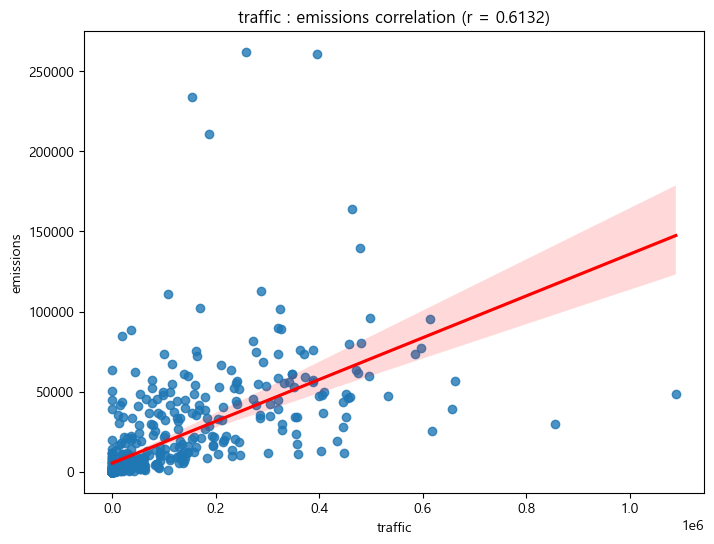

In [91]:
import seaborn as sns

# ÏÉÅÍ¥ÄÍ≥ÑÏàò Í≥ÑÏÇ∞
correlation = dj_co2["traffic"].corr(dj_co2["emissions"], method="pearson")

# Í≤∞Í≥º Ï∂úÎ†•
print(f"üìä ÍµêÌÜµÎüâ(traffic)ÏôÄ Ïò®Ïã§Í∞ÄÏä§ Î∞∞Ï∂úÎüâ(emissions)Ïùò ÌîºÏñ¥Ïä® ÏÉÅÍ¥ÄÍ≥ÑÏàò: {correlation:.4f}")

# ÏÇ∞Ï†êÎèÑ + ÌöåÍ∑ÄÏÑ† ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 6))
sns.regplot(x=dj_co2["traffic"], y=dj_co2["emissions"], line_kws={"color": "red"})
plt.xlabel("traffic")
plt.ylabel("emissions")
plt.title(f"traffic : emissions correlation (r = {correlation:.4f})")
plt.show()

In [92]:
dj_co2.to_csv('dj_co2_2.csv', index=False)

In [21]:
map.save_to_html(file_name="dj_sj_cj_map.html")

Map saved to dj_sj_cj_map.html!
